# An End-to-end Method for Producing Scanning-robust Stylized QR Codes

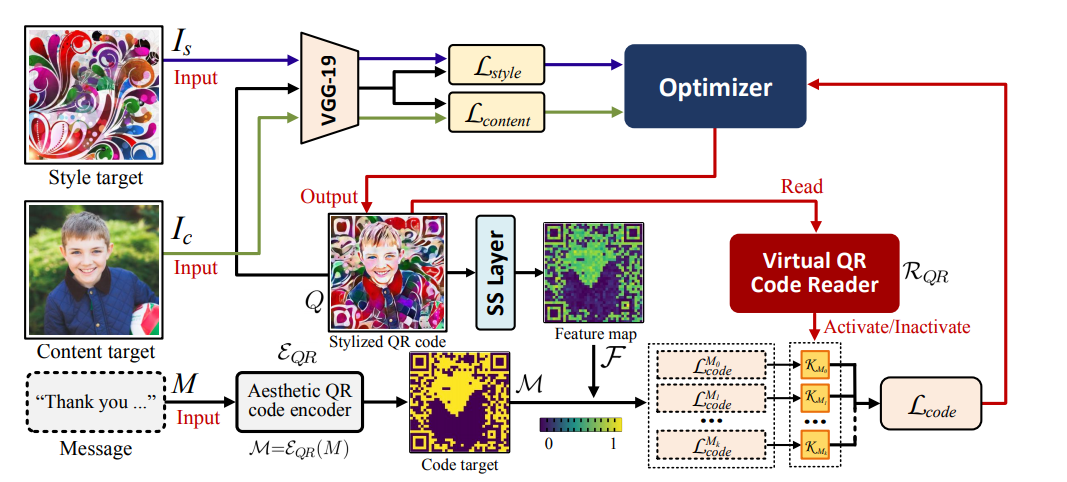

![Style transfer image](https://cdn-images-1.medium.com/max/1600/1*kOQOZxBDNw4lI757soTEyQ.png)

**Source - [Towards Data Science](https://towardsdatascience.com/real-time-video-neural-style-transfer-9f6f84590832)**

#  QR encoder

In [ ]:
#https://github.com/oostendo/python-zxing
!pip install zxing

In [ ]:
!pip install amzqr 

In [ ]:
!amzqr  "Thanks you.."

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread("/kaggle/working/qrcode.png"))

In [ ]:
import zxing
reader = zxing.BarCodeReader()

barcode = reader.decode("./qrcode.png")

In [ ]:
barcode.raw

In [ ]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import os
from keras import backend as K
from keras.preprocessing.image import load_img, save_img, img_to_array
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
#from keras import optimizers
from scipy.optimize import fmin_l_bfgs_b
#from keras.applications.vgg19 import VGG19
#vgg19_weights = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
#vgg19 = VGG19(include_top = False, weights=vgg19_weights)
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [ ]:
StylePath = '../input/best-artworks-of-all-time/images/images/'
ContentPath = '../input/image-classification/validation/validation/travel and adventure/'

## Loading the path for Base Content Image and the Style image respectively

In [ ]:
base_image_path = ContentPath+'13.jpg'
style_image_path = StylePath+'Pablo_Picasso/Pablo_Picasso_92.jpg'

In [ ]:
# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

## This function is used to Preprocess the image with help of VGG19.
**VGGNet** was invented by **VGG (Visual Geometry Group)** from University of Oxford, Though VGGNet was the 1st runner-up, not the winner of the ILSVRC (ImageNet Large Scale Visual Recognition Competition) 2014 in the classification task, which has significantly improvement over ZFNet (The winner in 2013) and AlexNet (The winner in 2012). And GoogLeNet is the winner of ILSVLC 2014, I will also talk about it later.) Nevertheless, VGGNet beats the GoogLeNet and won the localization task in ILSVRC 2014.<br><br>
**VGG19** is a model, with weights pre-trained on **ImageNet**.**ImageNet**, is a dataset of over 15 millions labeled high-resolution images with around 22,000 categories. ILSVRC uses a subset of ImageNet of around 1000 images in each of 1000 categories. In all, there are roughly 1.3 million training images, 50,000 validation images and 100,000 testing images.

In [ ]:
def preprocess_image(image_path):
    from keras.applications import vgg19
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [ ]:
plt.figure()
plt.title("Base Image",fontsize=20)
img1 = load_img(ContentPath+'13.jpg')
plt.imshow(img1)

In [ ]:
plt.figure()
plt.title("Style Image",fontsize=20)
img1 = load_img(StylePath+'Pablo_Picasso/Pablo_Picasso_92.jpg')
plt.imshow(img1)

In [ ]:
# get tensor representations of our images

base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_image_path))

In [ ]:
K.image_data_format()

### this will contain our generated image

Think of **Variable** in tensorflow as a normal variables which we use in programming languages. We initialize variables, we can modify it later as well. Whereas **placeholder** doesn’t require initial value. Placeholder simply allocates block of memory for future use. Later, we can use feed_dict to feed the data into placeholder. By default, placeholder has an unconstrained shape, which allows you to feed tensors of different shapes in a session.

In [ ]:
# this will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1,3,img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1,img_nrows, img_ncols,3))

In [ ]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image
                              ], axis=0)

## Building the VGG19 model

In [ ]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
from keras.applications.vgg19 import VGG19
vgg19_weights = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
model = VGG19(input_tensor=input_tensor,
              include_top = False,
              weights=vgg19_weights)
#model = vgg19.VGG19(input_tensor=input_tensor,
#                    weights='imagenet', include_top=False)
print('Model loaded.')


## Athough Vgg19 is basically used for Classification purpose, but here our objective is not to classify rather our objective is to transform a image, so we do not need all the layers of vgg19, we have specially excluded those layers which are used for classification.

In [ ]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1',
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
print(outputs_dict['block5_conv2'])

## The content Loss
Given a chosen content layer **l**, the content loss is defined as the Mean Squared Error between the feature map **F** of our content image **C** and the feature map **P** of our generated image **Y**.
![Coontent Loss](https://cdn-images-1.medium.com/max/800/1*1YfGhmzBw7EK3e8CRpZbuA.png)

In [ ]:
# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def get_content_loss(base_content, target):
    return K.sum(K.square(target - base_content))

## The Style Loss
To do this at first we need to, calculate the **Gram-matrix**(a matrix comprising of correlated features) for the tensors output by the style-layers. The Gram-matrix is essentially just a matrix of dot-products for the vectors of the feature activations of a style-layer.<br><br>
If an entry in the Gram-matrix has a value close to zero then it means the two features in the given layer do not activate simultaneously for the given style-image. And vice versa, if an entry in the Gram-matrix has a large value, then it means the two features do activate simultaneously for the given style-image. We will then try and create a mixed-image that replicates this activation pattern of the style-image.
If the feature map is a matrix **F**, then each entry in the Gram matrix **G** can be given by:
![Gram Matrix](https://cdn-images-1.medium.com/max/800/1*5xx9KmhVb59Mxe_buOwHBA.png)
The loss function for style is quite similar to out content loss, except that we calculate the Mean Squared Error for the Gram-matrices instead of the raw tensor-outputs from the layers.
![Style loss](https://cdn-images-1.medium.com/max/800/1*PuYveCM2BlgFfjUCr6I_Ng.png)

In [ ]:
import tensorflow as tf
# the gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(input_tensor):
    assert K.ndim(input_tensor)==3
    #if K.image_data_format() == 'channels_first':
    #    features = K.batch_flatten(input_tensor)
    #else:
    #    features = K.batch_flatten(K.permute_dimensions(input_tensor,(2,0,1)))
    #gram = K.dot(features, K.transpose(features))
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram#/tf.cast(n, tf.float32)

def get_style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows*img_ncols
    return K.sum(K.square(S - C))#/(4.0 * (channels ** 2) * (size ** 2))
    

## In the below four cells I have tried out my own way of extracting features from the style layers and content layers, but it didn't worked out successfully. So you can try out thse codes after modifying them, I hope it would work for you

In [ ]:
# Get output layers corresponding to style and content layers 
#style_outputs = [model.get_layer(name).output for name in style_layers]
#content_outputs = [model.get_layer(name).output for name in content_layers]
#model_outputs = style_outputs + content_outputs

In [ ]:
# Get the style and content feature representations from our model  
#style_features = [style_layer[0] for style_layer in model_outputs[:num_style_layers]]
#content_features = [content_layer[1] for content_layer in model_outputs[num_style_layers:]]

In [ ]:
 #gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

In [ ]:
#style_output_features = model_outputs[:num_style_layers]
#content_output_features = model_outputs[num_style_layers:]
# Accumulate style losses from all layers
# Here, we equally weight each contribution of each loss layer
#weight_per_style_layer = 1.0 / float(num_style_layers)
#loss = K.variable(0.0)
#style_score = 0
#content_score = 0
    
#for target_style, comb_style in zip(gram_style_features, style_output_features):
#    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
# Accumulate content losses from all layers 
#weight_per_content_layer = 1.0 / float(num_content_layers)
#for target_content, comb_content in zip(content_features, content_output_features):
#    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)

#style_score *= style_weight
#content_score *= content_weight

# Get total loss
#loss = style_score + content_score 

In [ ]:
content_weight=0.025 
style_weight=1.0
# combine these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
print('Layer Feature for Content Layers :: '+str(layer_features))
print('Base Image Feature :: '+str(base_image_features))
print('Combination Image Feature for Content Layers:: '+str(combination_features)+'\n')
loss += content_weight * get_content_loss(base_image_features,
                                      combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    print('Layer Feature for Style Layers :: '+str(layer_features))
    print('Style Image Feature :: '+str(style_reference_features))
    print('Combination Image Feature for Style Layers:: '+str(combination_features)+'\n')
    sl = get_style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl


## Features are extracted from each layer in style layers and content layers and their overall loss is calculated from it...

### This deprocess_image function is used return the original format of the Final image  after transformation which could be easily read and displayed by Matplotlib.

In [ ]:
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

### Calculation of gradient with respect to loss..

In [ ]:
# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)
grads

In [ ]:
outputs = [loss]
if isinstance(grads, (list,tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = K.function([combination_image], outputs)
f_outputs

**Athough there are various optimizers but we have used L-BFGS optimizer in this case, I have also gone through research papers where they have used ADAM optimizer to optimize the loss and get the final image.**

In [ ]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x_opt = preprocess_image(base_image_path)

In [ ]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


The purpose of this **Evaluator** class is to avoid the error **'numpy.ndarray' object is not callable error with optimize.minimize** while running the L-BFGS optimizer for loss minimization.<br><br>
You should pass the function itself to minimize, instead of a evaluated value. 

In [ ]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [ ]:
evaluator = Evaluator()

In this segment we run the code upto a given iteration. Although I would not recommend you to use **maxiter** parameter in **fmin_l_bfgs_b** to set the number of iterations.  Rarther use iteration in for loop to get better results

In [ ]:
iterations=10
# Store our best result
best_loss, best_img = float('inf'), None
for i in range(iterations):
    print('Start of iteration', i)
    x_opt, min_val, info= fmin_l_bfgs_b(evaluator.loss, 
                                        x_opt.flatten(), 
                                        fprime=evaluator.grads,
                                        maxfun=20,
                                        disp=True,
                                       )
    print('Current loss value:', min_val)
    if min_val < best_loss:
        # Update best loss and best image from total loss. 
        best_loss = min_val
        best_img = x_opt.copy()

**The Final Image**

In [ ]:
# save current generated image
imgx = deprocess_image(best_img.copy())
plt.imshow(imgx)

In [ ]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Base Image",fontsize=20)
img_base = load_img(base_image_path)
plt.imshow(img_base)

plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = load_img(style_image_path)
plt.imshow(img_style)

plt.subplot(5,5,1+2)
plt.title("Final Image",fontsize=20)
plt.imshow(imgx)

This function **Run_Style_Transfer** is nothing but combination of all the above code that is discussed in the above cells part by part. It returns the final image after style transfer between two images.

In [ ]:
def preprocess_image_instantiator(image_path,img_nrows,img_ncols):
    from keras.applications import vgg19
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [ ]:
def Run_StyleTransfer(base_image_path, style_image_path,qr_image_path ):
    
    width, height = load_img(base_image_path).size
    img_nrows = 400
    img_ncols = int(width * img_nrows / height)
    
    base_image = K.variable(preprocess_image_instantiator(base_image_path,img_nrows,img_ncols))
    style_reference_image = K.variable(preprocess_image_instantiator(style_image_path,img_nrows,img_ncols))
    qr_reference_image = K.variable(preprocess_image_instantiator(qr_image_path,img_nrows,img_ncols))
    
    if K.image_data_format() == 'channels_first':
        combination_image = K.placeholder((1,3,img_nrows, img_ncols))
    else:
        combination_image = K.placeholder((1,img_nrows, img_ncols,3))
        
    input_tensor = K.concatenate([base_image,
                                  style_reference_image,
                                  qr_reference_image,
                                  combination_image
                                  ], axis=0)
    from keras.applications.vgg19 import VGG19
    vgg19_weights = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
    model = VGG19(input_tensor=input_tensor,
                  include_top = False,
                  weights=vgg19_weights)
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
    
    content_weight=0.3
    style_weight=0.3
    qr_weight = 0.4
    # combine these loss functions into a single scalar
    loss = K.variable(0.0)
    layer_features = outputs_dict['block5_conv2']
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[3, :, :, :]
    #print('Layer Feature for Content Layers :: '+str(layer_features))
    #print('Base Image Feature :: '+str(base_image_features))
    #print('Combination Image Feature for Content Layers:: '+str(combination_image_features))
    loss += content_weight * get_content_loss(base_image_features,
                                          combination_features)
    
#     layer_features = outputs_dict['block5_conv2']
#     qr_image_features = layer_features[2, :, :, :]
#     combination_features = layer_features[3, :, :, :]
    
#     loss += qr_weight * get_content_loss(qr_image_features,
#                                           combination_features)
#     loss += qr_weight * get_content_loss(qr_reference_image,
#                                           combination_features)
    feature_layers = ['block1_conv1', 'block2_conv1',
                      'block3_conv1', 'block4_conv1',
                      'block5_conv1']
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[3, :, :, :]
        #print('Layer Feature for Style Layers :: '+str(layer_features))
        #print('Style Image Feature :: '+str(style_reference_features))
        #print('Combination Image Feature for Style Layers:: '+str(combination_features))
        sl = get_style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(feature_layers)) * sl
        
#         layer_features = outputs_dict[layer_name]
#         qr_reference_image = layer_features[2, :, :, :]
#         combination_features = layer_features[3, :, :, :]
#         sl = get_style_loss(qr_reference_image, combination_features)
#         loss += (qr_weight / len(feature_layers)) * sl
    # decoder loss
#     layer_features[1, :, :, :]

    
    grads = K.gradients(loss, combination_image)
    
    outputs = [loss]
    if isinstance(grads, (list,tuple)):
        outputs += grads
    else:
        outputs.append(grads)
    f_outputs = K.function([combination_image], outputs)
    
    x_opt = preprocess_image(base_image_path)
    
    evaluator = Evaluator()
    iterations=10
    # Store our best result
    best_loss, best_img = float('inf'), None
    for i in range(iterations):
        print('Start of iteration', i)
        x_opt, min_val, info= fmin_l_bfgs_b(evaluator.loss, 
                                            x_opt.flatten(), 
                                            fprime=evaluator.grads,
                                            maxfun=20,
                                            disp=True,
                                           )
        #print('Current loss value:', min_val)
        if min_val < best_loss:
            # Update best loss and best image from total loss. 
            best_loss = min_val
            best_img = x_opt.copy()
    imgx = deprocess_image(best_img.copy())
    
    return imgx

In [ ]:
import cv2
qr_image_path_1 = './qrcode.png'
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("QR Image",fontsize=20)
qr_base = load_img(qr_image_path_1)
plt.imshow(qr_base)

base_image_path_1 = '../input/image-classification/images/images/travel and  adventure/Places365_val_00005821.jpg'
plt.figure(figsize=(30,30))
plt.subplot(5,5,2)
plt.title("Base Image",fontsize=20)
img_base = load_img(base_image_path_1)
plt.imshow(img_base)

style_image_path_1 = '../input/best-artworks-of-all-time/images/images/Paul_Klee/Paul_Klee_96.jpg'
plt.subplot(5,5,3)
plt.title("Style Image",fontsize=20)
img_style = load_img(style_image_path_1)
plt.imshow(img_style)

plt.subplot(5,5,4)
imgg = Run_StyleTransfer(base_image_path_1, style_image_path_1,qr_image_path_1)
plt.title("Final Image",fontsize=20)
plt.imshow(imgg)

In [ ]:
# base_image_path_2 = '../input/image-classification/images/images/travel and  adventure/Places365_val_00005982.jpg'
# plt.figure(figsize=(30,30))
# plt.subplot(5,5,1)
# plt.title("Base Image",fontsize=20)
# img_base = load_img(base_image_path_2)
# plt.imshow(img_base)

# style_image_path_2 = '../input/best-artworks-of-all-time/images/images/Paul_Klee/Paul_Klee_24.jpg'
# plt.subplot(5,5,1+1)
# plt.title("Style Image",fontsize=20)
# img_style = load_img(style_image_path_2)
# plt.imshow(img_style)

# plt.subplot(5,5,1+2)
# imga = Run_StyleTransfer(base_image_path_2, style_image_path_2)
# plt.title("Final Image",fontsize=20)
# plt.imshow(imga)

In [ ]:
# base_image_path_3 = '../input/image-classification/images/images/travel and  adventure/Places365_val_00005752.jpg'
# plt.figure(figsize=(30,30))
# plt.subplot(5,5,1)
# plt.title("Base Image",fontsize=20)
# img_base = load_img(base_image_path_3)
# plt.imshow(img_base)

# style_image_path_3 = '../input/best-artworks-of-all-time/images/images/Paul_Klee/Paul_Klee_83.jpg'
# plt.subplot(5,5,1+1)
# plt.title("Style Image",fontsize=20)
# img_style = load_img(style_image_path_3)
# plt.imshow(img_style)

# plt.subplot(5,5,1+2)
# imgy = Run_StyleTransfer(base_image_path_3, style_image_path_3)
# plt.title("Final Image",fontsize=20)
# plt.imshow(imgy)

# Conclusion
* In our case the Final images formed are not totally perfect, because the Style image does not totally blend with the Base content image.
* It could be improved through icreasing the number of iteration, or by trying out a different syle transfer algorithm which could preseve the edges of the base image, or by trying out with different optimizer to minimize gradient and loss.